<a href="https://colab.research.google.com/github/kellyegorman/UNet-DenseNet-Blog/blob/main/densenet_visualization_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload

In [ ]:
dataname="synthetic"
gpuid=0

patch_size=224 #should match the value used to train the network

In [ ]:
import torch
print(torch.__version__)
import torchvision
print(torchvision.__version__)

2.5.1+cu124
0.20.1+cu124


In [ ]:
print(torch.cuda.get_device_properties(gpuid))
torch.cuda.set_device(gpuid)
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15095MB, multi_processor_count=40, uuid=3f36d7a0-8dcb-085f-7985-42dfa475dc85, L2_cache_size=4MB)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import tables
import math

import torch
from torchvision.models import DenseNet
from torch.autograd import Variable
from torchvision import transforms

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
%cd /gdrive/MyDrive/PytorchDigitalPathology/visualization_densenet

/gdrive/MyDrive/PytorchDigitalPathology/visualization_densenet


In [ ]:
import sys
sys.path.append('./pytorch-cnn-visualizations/')
from misc_functions import convert_to_grayscale

In [ ]:
checkpoint = torch.load(f"{dataname}_densenet_best_model.pth",  map_location=lambda storage, loc: storage) #load checkpoint to CPU and then put to dev

<ipython-input-25-7a9226b6c379>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"{dataname}_densenet_best_model.pth",  map_location=lambda storage,

In [ ]:
#load the model, note that the paramters are coming from the checkpoint, since the architecture of the model needs to exactly match the weights saved

model = DenseNet(growth_rate=checkpoint["growth_rate"], block_config=checkpoint["block_config"],
                 num_init_features=checkpoint["num_init_features"], bn_size=checkpoint["bn_size"], drop_rate=checkpoint["drop_rate"], num_classes=checkpoint["n_classes"]).to(device)

print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")
model.load_state_dict(checkpoint["model_dict"])

total params: 	58212


<All keys matched successfully>

In [ ]:
phase="val"
db=tables.open_file(f"./{dataname}_{phase}.pytable")

In [ ]:
img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
    transforms.ToTensor()
    ])

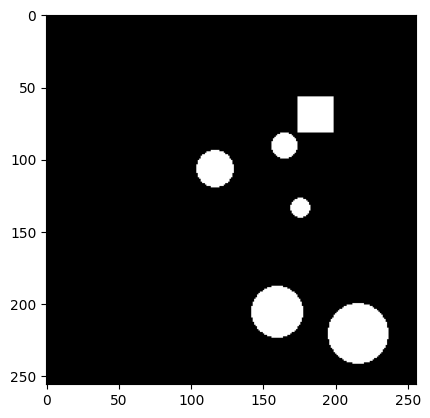

In [ ]:
imgid=19

img = db.root.imgs[imgid,::]
#label = torch.tensor(db.root.labels[imgid])
label = torch.tensor(np.array(db.root.labels[imgid]))

img = img[:,:,None].repeat(3,axis=2) #convert to 3 channel

timg=img_transform(img)

plt.imshow(img)

In [ ]:
model.eval()

timg = timg.to(device)  # [1, 3, H, W]
label = label.type('torch.LongTensor').to(device)  # [1] with class indices (0, 1)

output = model(timg[None,::])
output=output.detach().squeeze().cpu().numpy() #get output and pull it to CPU

predlabel=np.argmax(output)
print(f"class vals: {output}")
print(f"actual class: {label}")
print(f"predicted class: {predlabel}")

class vals: [-3.6377127  3.6255248]
actual class: 1
predicted class: 1


In [ ]:
def rescale_grads(map,gradtype="all"):
    if(gradtype=="pos"):    #positive
        map = (np.maximum(0, map) / map.max())
    elif gradtype=="neg":
        map = (np.maximum(0, -map) / -map.min())
    else:
        map = map - map.min()
        map /= map.max()
    return map

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


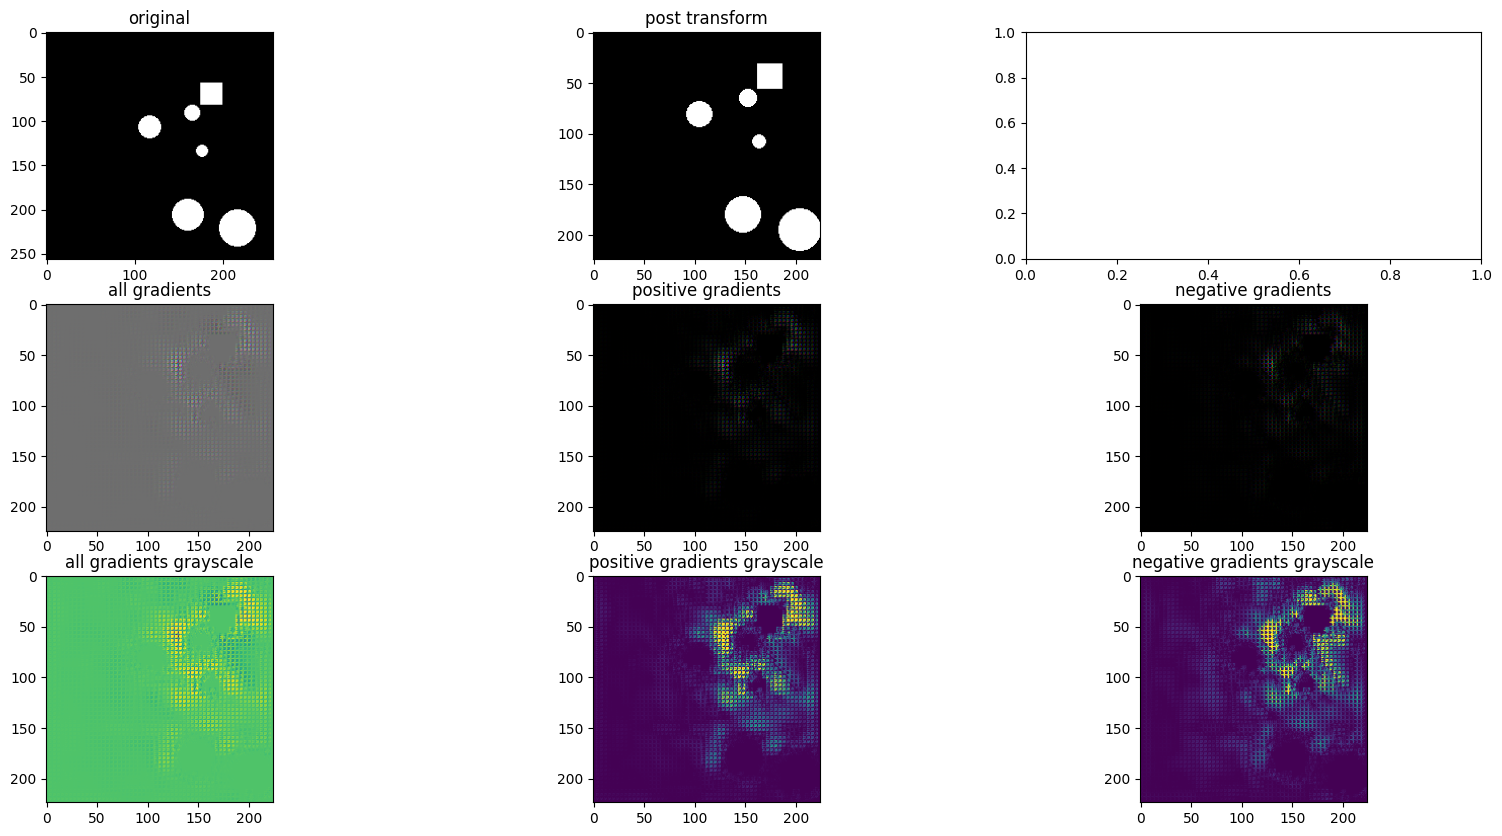

In [ ]:
from vanilla_backprop import VanillaBackprop
VBP = VanillaBackprop(model,device)
vanilla_grads = VBP.generate_gradients(timg[None,::], label)
vanilla_grads=np.moveaxis(vanilla_grads,0,-1)

fig, ax = plt.subplots(3,3, figsize=(20,10))
ax = ax.flatten()

ax[0].set_title("original")
ax[0].imshow(img)

ax[1].set_title("post transform")
ax[1].imshow(np.moveaxis(timg.cpu().numpy().squeeze(),0,-1))

ax[3].set_title("all gradients")
ax[3].imshow(rescale_grads(vanilla_grads,gradtype="all"))

ax[4].set_title("positive gradients")
ax[4].imshow(rescale_grads(vanilla_grads,gradtype="pos"))

ax[5].set_title("negative gradients")
ax[5].imshow(rescale_grads(vanilla_grads,gradtype="neg"))

ax[6].set_title("all gradients grayscale")
ax[6].imshow(convert_to_grayscale(rescale_grads(vanilla_grads,gradtype="all")))

ax[7].set_title("positive gradients grayscale")
ax[7].imshow(convert_to_grayscale(rescale_grads(vanilla_grads,gradtype="pos")))

ax[8].set_title("negative gradients grayscale")
ax[8].imshow(convert_to_grayscale(rescale_grads(vanilla_grads,gradtype="neg")))

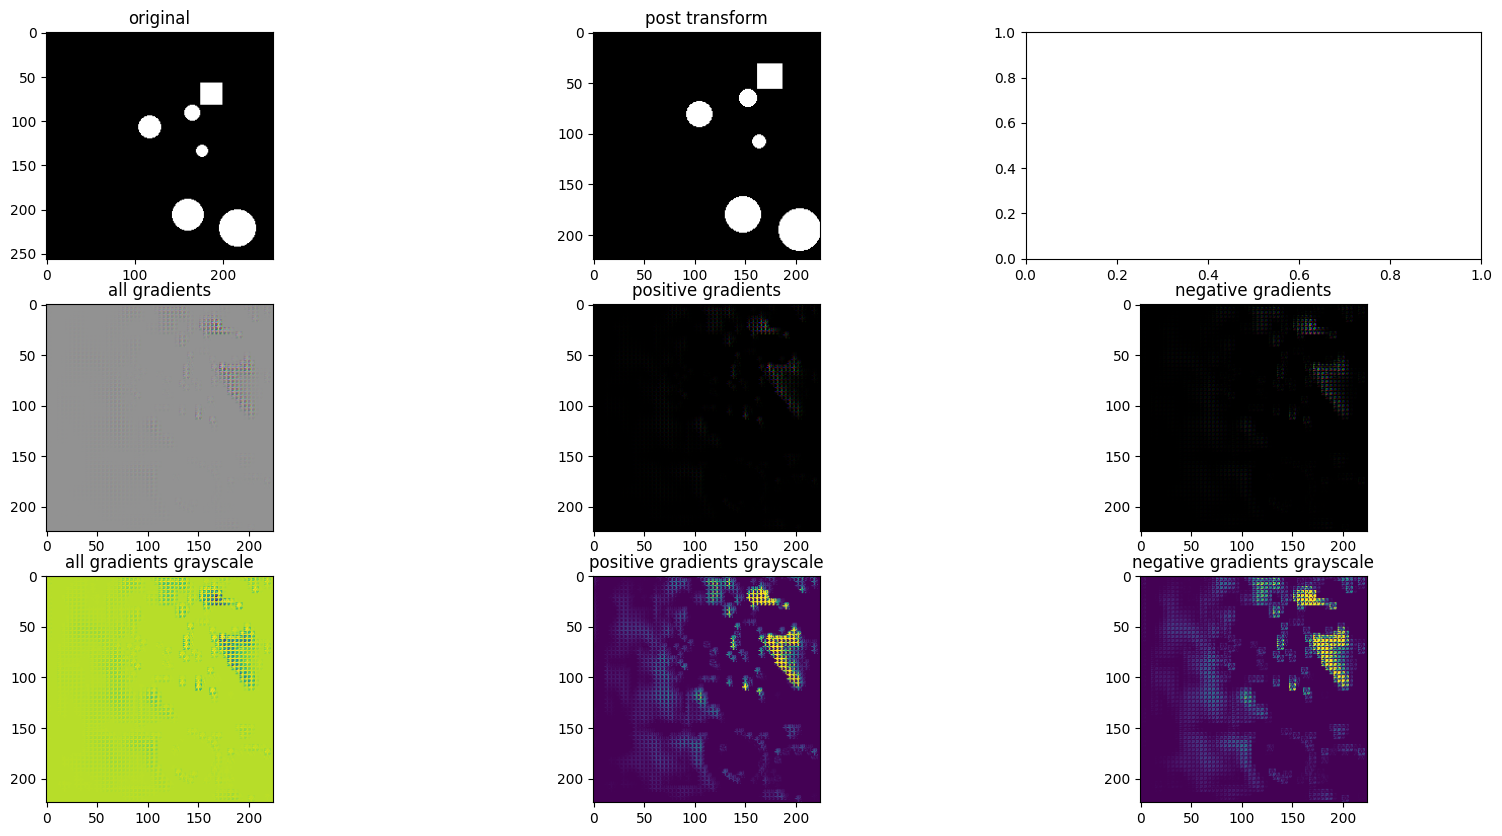

In [ ]:
from guided_backprop import GuidedBackprop
GB=GuidedBackprop(model,device)
gp_grads=GB.generate_gradients(timg[None,::], label)


gp_grads=np.moveaxis(gp_grads,0,-1)

fig, ax = plt.subplots(3,3, figsize=(20,10))
ax = ax.flatten()

ax[0].set_title("original")
ax[0].imshow(img)

ax[1].set_title("post transform")
ax[1].imshow(np.moveaxis(timg.cpu().numpy().squeeze(),0,-1))

ax[3].set_title("all gradients")
ax[3].imshow(rescale_grads(gp_grads,gradtype="all"))

ax[4].set_title("positive gradients")
ax[4].imshow(rescale_grads(gp_grads,gradtype="pos"))

ax[5].set_title("negative gradients")
ax[5].imshow(rescale_grads(gp_grads,gradtype="neg"))

ax[6].set_title("all gradients grayscale")
ax[6].imshow(convert_to_grayscale(rescale_grads(gp_grads,gradtype="all")))

ax[7].set_title("positive gradients grayscale")
ax[7].imshow(convert_to_grayscale(rescale_grads(gp_grads,gradtype="pos")))

ax[8].set_title("negative gradients grayscale")
ax[8].imshow(convert_to_grayscale(rescale_grads(gp_grads,gradtype="neg")))

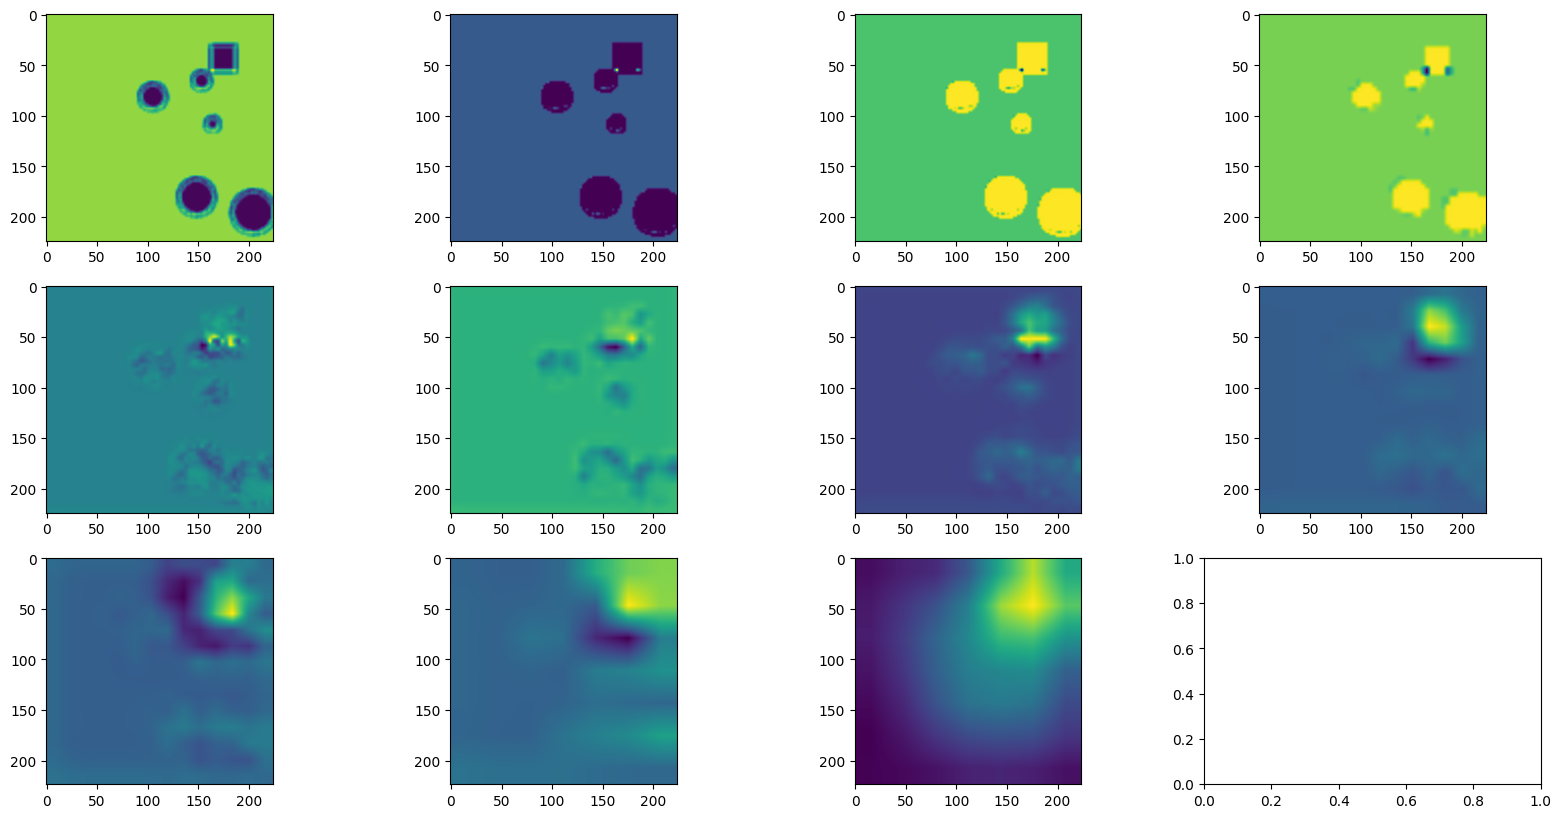

In [ ]:
from gradcam import GradCam

nlayers=len(model.features._modules.items())-1

fig, ax = plt.subplots(math.ceil(nlayers/4),4, figsize=(20,10))
ax = ax.flatten()

for layer in range(nlayers):
    grad_cam = GradCam(model, device,target_layer=layer)
    cam = grad_cam.generate_cam(timg[None,::], label)
    ax[layer].imshow(cam)

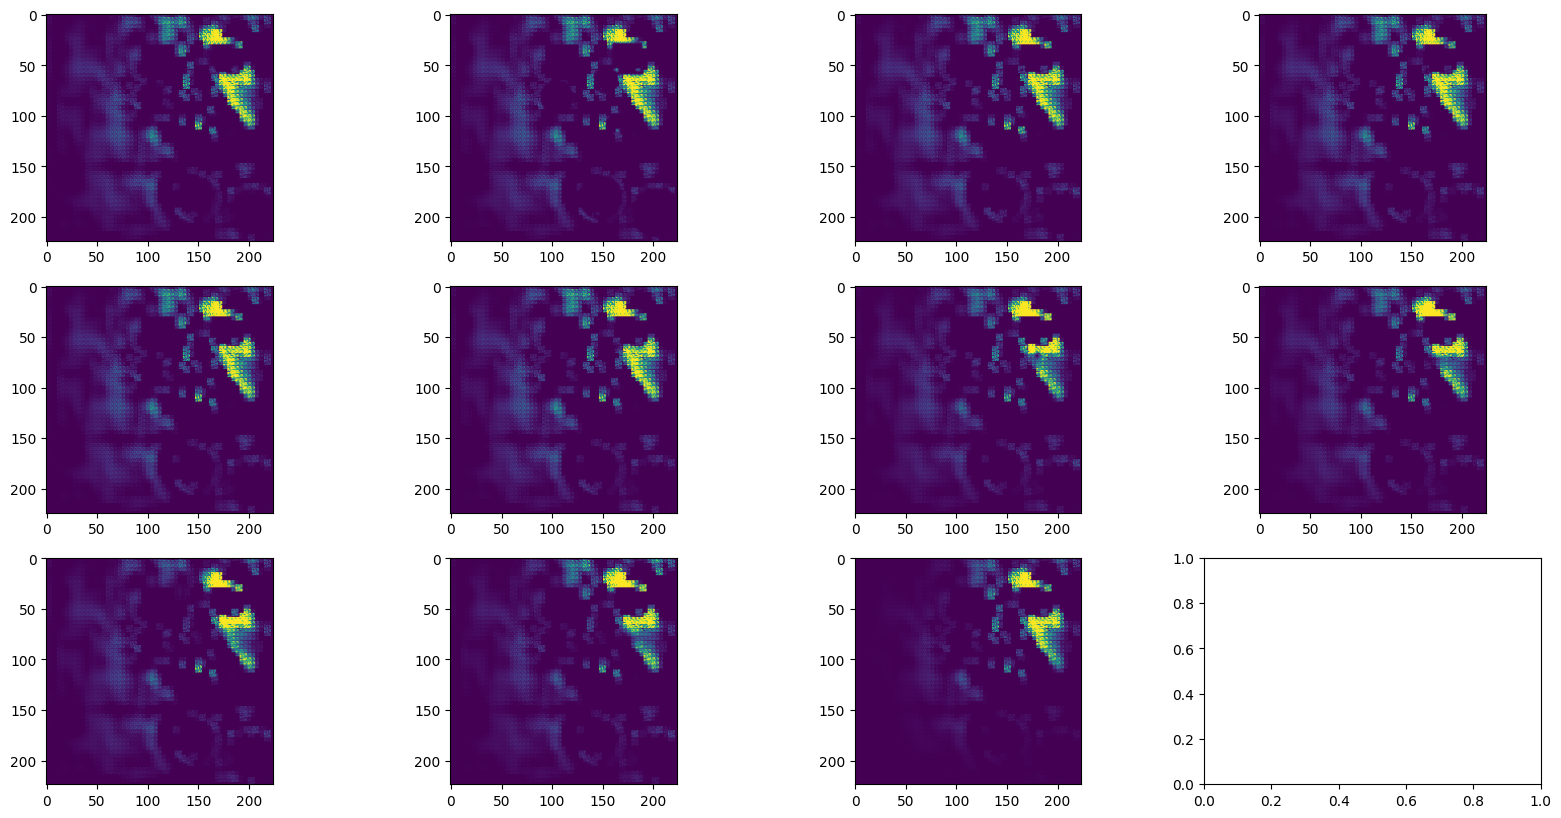

In [ ]:
from gradcam import GradCam
from guided_gradcam import guided_grad_cam
from guided_backprop import GuidedBackprop

nlayers=len(model.features._modules.items())-1

fig, ax = plt.subplots(math.ceil(nlayers/4),4, figsize=(20,10))
ax = ax.flatten()

for layer in range(nlayers):
    #GradCam
    grad_cam = GradCam(model, device,target_layer=layer)
    cam = grad_cam.generate_cam(timg[None,::], label)

    #GuidedBackprop
    GBP = GuidedBackprop(model, device)
    guided_grads = GBP.generate_gradients(timg[None,::], label)

    # Guided Grad cam
    cam_gb = guided_grad_cam(cam, guided_grads)

    ax[layer].imshow(convert_to_grayscale(np.moveaxis(cam_gb,0,-1)))

In [ ]:
!pip install python-pptx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 6.0 MB/s eta 0:00:00


In [ ]:
from pptx import Presentation
from pptx.util import Inches
from datetime import datetime
import numpy as np
import torch
import cv2
from torchvision import transforms
import matplotlib.pyplot as plt
from io import BytesIO
import PIL.Image as Image
import tables
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
base_path = "/content/drive/MyDrive/PytorchDigitalPathology/visualization_densenet"
pptx_fname = f"{base_path}/densenet_results.pptx"

# Load the trained DenseNet model
checkpoint = torch.load(f"{base_path}/synthetic_densenet_best_model.pth", map_location=torch.device('cpu'))
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
model.classifier = torch.nn.Linear(model.classifier.in_features, checkpoint["n_classes"])
# model.load_state_dict(checkpoint["model_dict"])
model.eval()

# Load dataset
phase = "val"
db = tables.open_file(f"{base_path}/synthetic_{phase}.pytable")

# Image transformation
patch_size = 224
img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((patch_size, patch_size)),
    transforms.ToTensor()
])

# Function to add an image to a slide
def add_image_to_slide(slide, img, left, top, height, width):
    image_stream = BytesIO()
    Image.fromarray(img).save(image_stream, format="PNG")
    slide.shapes.add_picture(image_stream, left, top, height, width)
    image_stream.close()

# Function to generate model prediction
def predict_image(image):
    image_tensor = img_transform(image).unsqueeze(0)  # Add batch dimension
    output = model(image_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1).detach().numpy().squeeze()
    predicted_class = np.argmax(probabilities)
    return predicted_class, probabilities

# Create PowerPoint presentation
prs = Presentation()
prs.slide_width = Inches(10)
prs.slide_height = Inches(10)

# Metadata Slide
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.placeholders[0].text = "DenseNet Model Results"
tf = slide.placeholders[1].text_frame
tf.text = f"Date: {datetime.today().strftime('%Y-%m-%d')}\n"
tf.text += "Author: Kelly Gorman\n"
tf.text += "Comments: Model predictions with Grad-CAM & Backpropagation\n"

# Process and visualize images
num_images = 10  # Set the number of images to process
for img_id in range(num_images):
    slide = prs.slides.add_slide(prs.slide_layouts[0])  # Add new slide

    # Load image from dataset
    img = db.root.imgs[img_id, ::]
    img = img[:, :, None].repeat(3, axis=2)  # Convert grayscale to 3-channel

    # Get prediction
    pred_class, probs = predict_image(img)

    # Add original image
    add_image_to_slide(slide, img, Inches(0), Inches(0), Inches(5), Inches(5))

    # Add transformed image
    transformed_img = img_transform(img).permute(1, 2, 0).numpy() * 255
    add_image_to_slide(slide, transformed_img.astype(np.uint8), Inches(5), Inches(0), Inches(5), Inches(5))

    # Display Grad-CAM (Placeholder - Replace with actual Grad-CAM function)
    grad_cam_img = np.random.randint(0, 255, (patch_size, patch_size, 3), dtype=np.uint8)  # Fake Grad-CAM
    add_image_to_slide(slide, grad_cam_img, Inches(0), Inches(5), Inches(5), Inches(5))

    # Display Vanilla Backpropagation (Placeholder)
    vanilla_bp_img = np.random.randint(0, 255, (patch_size, patch_size, 3), dtype=np.uint8)
    add_image_to_slide(slide, vanilla_bp_img, Inches(5), Inches(5), Inches(5), Inches(5))

    # Add text box with results
    text_box = slide.shapes.add_textbox(Inches(10), Inches(0), Inches(4), Inches(4))
    text_frame = text_box.text_frame
    text_frame.text = f"Image {img_id}\n"
    text_frame.text += f"Predicted Class: {pred_class}\n"
    text_frame.text += f"Confidence Scores: {probs}\n"

# Save PowerPoint
prs.save(pptx_fname)
print(f"Presentation saved at {pptx_fname}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-10-901f43608856>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"{base_path}/synthetic_densenet_best_model.pth", map_location=torc

Presentation saved at /content/drive/MyDrive/PytorchDigitalPathology/visualization_densenet/densenet_results.pptx
